# Multi-Agent Applications: Building Agent Teams with LangGraph

In this notebook, we'll explore **multi-agent systems** - applications where multiple specialized agents collaborate to solve complex tasks. We'll build on our LangGraph foundation from Session 4 and create agent teams for our Personal Wellness Assistant.

**Learning Objectives:**
- Understand when and why to use multi-agent systems
- Master the Supervisor pattern for orchestrating agent teams
- Implement Agent Handoffs for dynamic task routing
- Use Tavily Search for web research capabilities
- Apply context engineering principles to optimize agent performance
- Visualize and debug multi-agent systems with LangSmith

## Table of Contents:

- **Breakout Room #1:** Multi-Agent Fundamentals & Supervisor Pattern
  - Task 1: Dependencies & Environment Setup
  - Task 2: Understanding Multi-Agent Systems
  - Task 3: Building a Supervisor Agent Pattern
  - Task 4: Adding Tavily Search for Web Research
  - Question #1 & Question #2
  - Activity #1: Add a Custom Specialist Agent

- **Breakout Room #2:** Handoffs & Context Engineering
  - Task 5: Agent Handoffs Pattern
  - Task 6: Building a Wellness Agent Team
  - Task 7: Context Engineering & Optimization
  - Task 8: Visualizing and Debugging with LangSmith
  - Question #3 & Question #4
  - Activity #2: Implement Hierarchical Teams

---
# 🤝 Breakout Room #1
## Multi-Agent Fundamentals & Supervisor Pattern

## Task 1: Dependencies & Environment Setup

Before we begin, make sure you have:

1. **API Keys** for:
   - OpenAI (for GPT-5.2 supervisor and GPT-4o-mini specialist agents)
   - Tavily (free tier at [tavily.com](https://www.tavily.com/))
   - LangSmith (optional, for tracing)

2. **Dependencies installed** via `uv sync`

**Models Used:**
- **GPT-5.2**: Supervisor/orchestrator agents (better reasoning for routing decisions)
- **GPT-4o-mini**: Specialist agents (cost-effective for domain-specific tasks)

**Documentation:**
- [Tavily Search API](https://docs.tavily.com/)

In [2]:
# Core imports
import os
import getpass
import json
from uuid import uuid4
from typing import Annotated, TypedDict, Literal, Sequence
import operator

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

In [3]:
# Set API Keys
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key: ")

In [4]:
# Tavily API Key for web search
os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key: ")

In [5]:
# Optional: LangSmith for tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - Multi-Agent Applications - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key (press Enter to skip): ") or ""

if not os.environ["LANGCHAIN_API_KEY"]:
    os.environ["LANGCHAIN_TRACING_V2"] = "false"
    print("LangSmith tracing disabled")
else:
    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

LangSmith tracing enabled. Project: AIE9 - Multi-Agent Applications - 76727561


In [6]:
# Initialize LLMs - GPT-5.2 for supervisors, GPT-4o-mini for specialists
from langchain_openai import ChatOpenAI

# Supervisor model - better reasoning for routing and orchestration
supervisor_llm = ChatOpenAI(model="gpt-5.2", temperature=0)

# Specialist model - cost-effective for domain-specific tasks
specialist_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Test both models
print("Testing models...")
supervisor_response = supervisor_llm.invoke("Say 'Supervisor ready!' in exactly 2 words.")
specialist_response = specialist_llm.invoke("Say 'Specialist ready!' in exactly 2 words.")

print(f"Supervisor (GPT-5.2): {supervisor_response.content}")
print(f"Specialist (GPT-4o-mini): {specialist_response.content}")

Testing models...
Supervisor (GPT-5.2): Supervisor ready!
Specialist (GPT-4o-mini): Specialist ready!


In [ ]:
import os
import requests
   
api_key = os.environ.get("LANGCHAIN_API_KEY")
if api_key:
    # Test the key with a simple LangSmith API call
    headers = {"x-api-key": api_key}
    response = requests.get("https://api.smith.langchain.com/api/v1/info", headers=headers)
    print(f"Status: {response.status_code}")
    if response.status_code == 200:
        print("✓ Key is valid and working!")
    else:
        print(f"✗ Error: {response.text}")

Status: 200
✓ Key is valid and working!


## Task 2: Understanding Multi-Agent Systems

### When to Use Multi-Agent Systems

Before building multi-agent systems, ask yourself:

> **"Do I really need several specialized dynamic reasoning machines collaborating to solve this task more effectively than a single agent could?"**

Multi-agent systems are useful when:
1. **Tool/responsibility grouping**: Different tasks require different expertise
2. **Prompt separation**: Different agents need different instructions/few-shot examples
3. **Piecewise optimization**: Easier to improve individual components

### Key Multi-Agent Patterns

| Pattern | Description | Use Case |
|---------|-------------|----------|
| **Supervisor** | Central orchestrator routes to specialist agents | Task delegation, quality control |
| **Handoffs** | Agents transfer control to each other | Conversation flows, expertise routing |
| **Hierarchical** | Supervisors manage teams of agents | Large-scale systems, departments |
| **Network/Swarm** | Agents communicate freely | Collaborative problem-solving |

### Context Engineering Principles

From leading practitioners:

- **Dex Horthy (12-Factor Agents)**: "Own your context window and treat it like prime real estate"
- **swyx (Agent Engineering)**: "Agent reliability = great context construction"
- **Chroma (Context Rot)**: "Longer ≠ better when it comes to context"

**Documentation:**
- [Building Effective Agents (Anthropic)](https://www.anthropic.com/engineering/building-effective-agents)
- [Don't Build Multi-Agents (Cognition)](https://cognition.ai/blog/dont-build-multi-agents)
- [12-Factor Agents](https://github.com/humanlayer/12-factor-agents)

## Task 3: Building a Supervisor Agent Pattern

The **Supervisor Pattern** uses a central agent to:
1. Analyze incoming requests
2. Route to the appropriate specialist agent
3. Aggregate and refine responses

```
                    ┌─────────────────┐
                    │   Supervisor    │
                    │   (Orchestrator)│
                    └────────┬────────┘
                             │
           ┌─────────────────┼─────────────────┐
           │                 │                 │
           ▼                 ▼                 ▼
    ┌────────────┐    ┌────────────┐    ┌────────────┐
    │  Exercise  │    │  Nutrition │    │   Sleep    │
    │   Agent    │    │   Agent    │    │   Agent    │
    └────────────┘    └────────────┘    └────────────┘
```

**Documentation:**
- [LangGraph Supervisor Tutorial](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/)

In [12]:
# Import LangGraph and LangChain components
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.agents import create_agent  # LangChain 1.0 API
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_core.tools import tool

print("LangGraph and LangChain components imported!")

LangGraph and LangChain components imported!


In [13]:
# First, let's set up our RAG system for the wellness knowledge base
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Load and chunk the wellness document
loader = TextLoader("data/HealthWellnessGuide.txt")
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)
chunks = text_splitter.split_documents(documents)

print(f"Loaded and split into {len(chunks)} chunks")

Loaded and split into 45 chunks


In [14]:
# Set up vector store
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
embedding_dim = len(embedding_model.embed_query("test"))

qdrant_client = QdrantClient(":memory:")
qdrant_client.create_collection(
    collection_name="wellness_multiagent",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE)
)

vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name="wellness_multiagent",
    embedding=embedding_model
)
vector_store.add_documents(chunks)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})
print(f"Vector store ready with {len(chunks)} documents")

Vector store ready with 45 documents


In [15]:
# Create specialized tools for each agent domain

@tool
def search_exercise_info(query: str) -> str:
    """Search for exercise, fitness, and workout information from the wellness knowledge base.
    Use this for questions about physical activity, workout routines, and exercise techniques.
    """
    results = retriever.invoke(f"exercise fitness workout {query}")
    if not results:
        return "No exercise information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_nutrition_info(query: str) -> str:
    """Search for nutrition, diet, and healthy eating information from the wellness knowledge base.
    Use this for questions about food, meal planning, and dietary guidelines.
    """
    results = retriever.invoke(f"nutrition diet food meal {query}")
    if not results:
        return "No nutrition information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_sleep_info(query: str) -> str:
    """Search for sleep, rest, and recovery information from the wellness knowledge base.
    Use this for questions about sleep quality, insomnia, and sleep hygiene.
    """
    results = retriever.invoke(f"sleep rest recovery insomnia {query}")
    if not results:
        return "No sleep information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_stress_info(query: str) -> str:
    """Search for stress management and mental wellness information from the wellness knowledge base.
    Use this for questions about stress, anxiety, mindfulness, and mental health.
    """
    results = retriever.invoke(f"stress mental wellness mindfulness anxiety {query}")
    if not results:
        return "No stress management information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

print("Specialist tools created!")

Specialist tools created!


In [16]:
# Create specialist agents using create_agent (LangChain 1.0 API)
# Each specialist uses GPT-4o-mini for cost efficiency

exercise_agent = create_agent(
    model=specialist_llm,
    tools=[search_exercise_info],
    system_prompt="You are an Exercise Specialist. Help users with workout routines, fitness tips, and physical activity guidance. Always search the knowledge base before answering. Be concise and helpful."
)

nutrition_agent = create_agent(
    model=specialist_llm,
    tools=[search_nutrition_info],
    system_prompt="You are a Nutrition Specialist. Help users with diet advice, meal planning, and healthy eating. Always search the knowledge base before answering. Be concise and helpful."
)

sleep_agent = create_agent(
    model=specialist_llm,
    tools=[search_sleep_info],
    system_prompt="You are a Sleep Specialist. Help users with sleep quality, insomnia, and rest optimization. Always search the knowledge base before answering. Be concise and helpful."
)

stress_agent = create_agent(
    model=specialist_llm,
    tools=[search_stress_info],
    system_prompt="You are a Stress Management Specialist. Help users with stress relief, mindfulness, and mental wellness. Always search the knowledge base before answering. Be concise and helpful."
)

print("Specialist agents created (using GPT-4o-mini with create_agent)!")

Specialist agents created (using GPT-4o-mini with create_agent)!


In [18]:
# Define the supervisor state and routing
from typing import List
from pydantic import BaseModel

# Define routing options - supervisor picks ONE specialist, then that specialist responds
class RouterOutput(BaseModel):
    """The supervisor's routing decision."""
    next: Literal["exercise", "nutrition", "sleep", "stress"]
    reasoning: str

class SupervisorState(TypedDict):
    """State for the supervisor multi-agent system."""
    messages: Annotated[list[BaseMessage], add_messages]
    next: str

print("Supervisor state defined!")

Supervisor state defined!


In [19]:
# Create the supervisor node (using GPT-5.2 for routing decisions)
from langchain_core.prompts import ChatPromptTemplate

supervisor_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a Wellness Supervisor coordinating a team of specialist agents.

Your team:
- exercise: Handles fitness, workouts, physical activity, movement questions
- nutrition: Handles diet, meal planning, healthy eating, food questions
- sleep: Handles sleep quality, insomnia, rest, recovery questions
- stress: Handles stress management, mindfulness, mental wellness, anxiety questions

Based on the user's question, decide which ONE specialist should respond.
Choose the most relevant specialist for the primary topic of the question."""),
    ("human", "User question: {question}\n\nWhich specialist should handle this?")
])

# Create structured output for routing (using GPT-5.2)
routing_llm = supervisor_llm.with_structured_output(RouterOutput)

def supervisor_node(state: SupervisorState):
    """The supervisor decides which agent to route to."""
    # Get the user's question from the last human message
    user_question = ""
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            user_question = msg.content
            break
    
    # Get routing decision
    prompt_value = supervisor_prompt.invoke({"question": user_question})
    result = routing_llm.invoke(prompt_value)
    
    print(f"[Supervisor GPT-5.2] Routing to: {result.next}")
    print(f"  Reason: {result.reasoning}")
    
    return {"next": result.next}

print("Supervisor node created (using GPT-5.2)!")

Supervisor node created (using GPT-5.2)!


In [20]:
# Create agent nodes that wrap the specialist agents

def create_agent_node(agent, name: str):
    """Create a node that runs a specialist agent and returns the final response."""
    def agent_node(state: SupervisorState):
        print(f"[{name.upper()} Agent] Processing request...")
        
        # Invoke the specialist agent with the conversation
        result = agent.invoke({"messages": state["messages"]})
        
        # Get the agent's final response
        agent_response = result["messages"][-1]
        
        # Add agent identifier to the response
        response_with_name = AIMessage(
            content=f"[{name.upper()} SPECIALIST]\n\n{agent_response.content}",
            name=name
        )
        
        print(f"[{name.upper()} Agent] Response complete.")
        return {"messages": [response_with_name]}
    
    return agent_node

# Create nodes for each specialist
exercise_node = create_agent_node(exercise_agent, "exercise")
nutrition_node = create_agent_node(nutrition_agent, "nutrition")
sleep_node = create_agent_node(sleep_agent, "sleep")
stress_node = create_agent_node(stress_agent, "stress")

print("Agent nodes created!")

Agent nodes created!


In [21]:
# Build the supervisor graph
# KEY: Specialists go directly to END (no loop back to supervisor)

def route_to_agent(state: SupervisorState) -> str:
    """Route to the next agent based on supervisor decision."""
    return state["next"]

# Create the graph
supervisor_workflow = StateGraph(SupervisorState)

# Add nodes
supervisor_workflow.add_node("supervisor", supervisor_node)
supervisor_workflow.add_node("exercise", exercise_node)
supervisor_workflow.add_node("nutrition", nutrition_node)
supervisor_workflow.add_node("sleep", sleep_node)
supervisor_workflow.add_node("stress", stress_node)

# Add edges: START -> supervisor
supervisor_workflow.add_edge(START, "supervisor")

# Conditional routing from supervisor to specialists
supervisor_workflow.add_conditional_edges(
    "supervisor",
    route_to_agent,
    {
        "exercise": "exercise",
        "nutrition": "nutrition",
        "sleep": "sleep",
        "stress": "stress",
    }
)

# KEY FIX: Each specialist goes directly to END (no looping!)
supervisor_workflow.add_edge("exercise", END)
supervisor_workflow.add_edge("nutrition", END)
supervisor_workflow.add_edge("sleep", END)
supervisor_workflow.add_edge("stress", END)

# Compile
supervisor_graph = supervisor_workflow.compile()

print("Supervisor multi-agent system built!")
print("Flow: User -> Supervisor -> Specialist -> END")

Supervisor multi-agent system built!
Flow: User -> Supervisor -> Specialist -> END


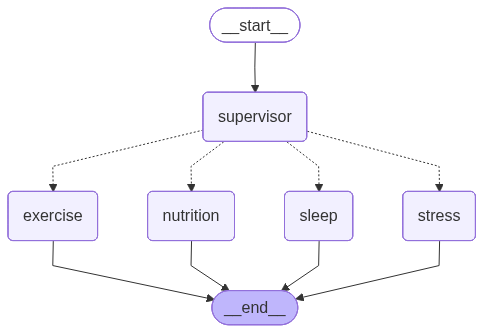

In [22]:
# Visualize the graph
try:
    from IPython.display import display, Image
    display(Image(supervisor_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(supervisor_graph.get_graph().draw_ascii())

In [23]:
# Test the supervisor system
print("Testing Supervisor Multi-Agent System")
print("=" * 50)

response = supervisor_graph.invoke({
    "messages": [HumanMessage(content="What exercises can help with ankle strength?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Supervisor Multi-Agent System
[Supervisor GPT-5.2] Routing to: exercise
  Reason: The user is asking for exercises to improve ankle strength, which falls under fitness training, movement, and strengthening protocols—best handled by the exercise specialist.
[EXERCISE Agent] Processing request...
[EXERCISE Agent] Response complete.

Final Response:
[EXERCISE SPECIALIST]

Here are some effective exercises to help strengthen your ankles:

1. **Ankle Circles**: Sit or stand and lift one foot off the ground. Rotate your ankle in a circular motion, making 10 circles in each direction. Repeat with the other ankle.

2. **Heel Raises**: Stand with your feet shoulder-width apart. Slowly raise your heels off the ground, balancing on your toes. Hold for a moment, then lower back down. Aim for 10-15 repetitions.

3. **Toe Raises**: Stand and lift your toes off the ground while keeping your heels down. Hold for a moment, then lower. Perform 10-15 repetitions.

4. **Resistance Band Exercises**

In [24]:
# Test with a nutrition question
print("Testing with nutrition question")
print("=" * 50)

response = supervisor_graph.invoke({
    "messages": [HumanMessage(content="What should I eat for better hair?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing with nutrition question
[Supervisor GPT-5.2] Routing to: nutrition
  Reason: The user is asking what to eat to improve hair health, which is primarily a diet and nutrient intake question best addressed by the nutrition specialist.
[NUTRITION Agent] Processing request...
[NUTRITION Agent] Response complete.

Final Response:
[NUTRITION SPECIALIST]

To promote better hair health, consider incorporating the following foods into your diet:

1. **Fruits and Vegetables**: Aim for a variety of colorful options, as they are rich in vitamins and antioxidants that support hair health.

2. **Lean Proteins**: Include sources like chicken, fish, eggs, and legumes. Proteins are essential for hair structure and growth.

3. **Healthy Fats**: Incorporate foods like avocados, nuts, seeds, and fatty fish (like salmon) to provide essential fatty acids that nourish the scalp.

4. **Whole Grains**: Choose complex carbohydrates such as brown rice, quinoa, and whole grain bread for sustained energy and

## Task 4: Adding Tavily Search for Web Research

Sometimes the wellness knowledge base doesn't have the latest information. Let's add **Tavily Search** to allow agents to search the web for current information.

**Documentation:**
- [Tavily Search Tool](https://python.langchain.com/docs/integrations/tools/tavily_search/)
- [Tavily API Docs](https://docs.tavily.com/)

In [25]:
# Create a Tavily search tool (using updated langchain-tavily package)
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(
    max_results=3,
    topic="general"
)

print(f"Tavily search tool created: {tavily_search.name}")

Tavily search tool created: tavily_search


In [26]:
# Test Tavily search
search_results = tavily_search.invoke("latest research on benefits of morning exercise 2024")
print("Tavily Search Results:")
print("-" * 50)

for result in search_results['results'][:2]:
    print(f"\nTitle: {result.get('title', 'N/A')}")
    print(f"URL: {result.get('url', 'N/A')}")
    print(f"Content: {result.get('content', 'N/A')[:200]}...")

Tavily Search Results:
--------------------------------------------------

Title: Differential benefits of 12-week morning vs. evening ...
URL: https://www.nature.com/articles/s41598-025-02659-8
Content: by B Shen · 2025 · Cited by 11 — Morning exercise (6–8 am) is particularly effective for rapid body fat reduction, lowering plasma cholesterol and triglycerides, and advancing sleep-wake cycle....

Title: Comparative effectiveness of morning and evening aerobic ...
URL: https://pmc.ncbi.nlm.nih.gov/articles/PMC12036172/
Content: by J Sun · 2025 · Cited by 1 — Studies indicate that morning exercise is more effective for weight loss in college students who are overweight and obese, with a significant...


In [27]:
# Create a research agent that can search both the knowledge base AND the web
@tool
def search_wellness_kb(query: str) -> str:
    """Search the local wellness knowledge base for established health information.
    Use this first for general wellness questions.
    """
    results = retriever.invoke(query)
    if not results:
        return "No information found in knowledge base."
    return "\n\n".join([f"[KB Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_web_current(query: str) -> str:
    """Search the web for current/recent health and wellness information.
    Use this when you need the latest research, news, or information not in the knowledge base.
    """
    response = tavily_search.invoke(query)
    if not response or not response.get('results'):
        return "No web results found."
    formatted = []
    for i, r in enumerate(response['results'][:3]):
        formatted.append(f"[Web Source {i+1}]: {r.get('content', 'N/A')}\nURL: {r.get('url', 'N/A')}")
    return "\n\n".join(formatted)

# Create a research agent with both tools (using create_agent)
research_agent = create_agent(
    model=specialist_llm,
    tools=[search_wellness_kb, search_web_current],
    system_prompt="""You are a Wellness Research Agent. You have access to both a curated knowledge base 
and web search. Use the knowledge base for established information and web search for 
current/recent updates. Always cite your sources."""
)

print("Research agent with web search created (using create_agent)!")

Research agent with web search created (using create_agent)!


In [28]:
# Test the research agent
print("Testing Research Agent (KB + Web)")
print("=" * 50)

response = research_agent.invoke({
    "messages": [HumanMessage(content="What are the benefits of cold water immersion for recovery?")]
})

print("\nResearch Agent Response:")
print(response["messages"][-1].content)

Testing Research Agent (KB + Web)

Research Agent Response:
Cold water immersion (CWI), commonly known as ice baths, has gained popularity as a recovery technique among athletes and fitness enthusiasts. Here are some of the key benefits associated with cold water immersion for recovery:

1. **Reduces Inflammation and Muscle Soreness**: Cold water immersion is effective in reducing inflammation and muscle soreness, particularly after intense physical exercise. This can help speed up recovery time and alleviate delayed onset muscle soreness (DOMS) (Web Source 1).

2. **Improved Circulation**: Immersing the body in cold water causes blood vessels to constrict, which can help reduce swelling and inflammation. Once out of the cold water, the vessels dilate, leading to improved circulation and the flushing out of metabolic waste products from the muscles (Web Source 1).

3. **Enhanced Recovery**: CWI has been shown to improve recovery times for athletes by reducing muscle damage and fatigue.

---
## ❓ Question #1:

In the Supervisor pattern, the supervisor routes requests to specialist agents. What are the **advantages** and **disadvantages** of having agents loop back to the supervisor after responding, versus having them respond directly to the user?

##### Answer:
When we have the specialist agents loop back to supervisor, we can have supervisor to synthesize responses from multiple specialist agents before responding to the user. It can also help when we want supervisor to do some additional processing on top of the individual responses of the agents. We can control the aspects of the final response, like style, format etc. in single place (supervisor).
The diadvantage is additional loop and latency involved. When there is no additional benefit that the surpervisor provides, this is inefficient.
On the other hand, having specialist agents respond directly to the user is simpler and more efficient.

## ❓ Question #2:

We added Tavily web search alongside the knowledge base. In what scenarios would you want to **restrict** an agent to only use the knowledge base (no web search)? What are the trade-offs between freshness and reliability?

##### Answer:
Say for example in a customer service agent, where Tavily web search might help to get real-time information like weather, events etc., the responses related to policy and products must come only from the knowledge base provided. Opening this up to web might provide some inconsistent and inaacurate information to the user.

---
## 🏗️ Activity #1: Add a Custom Specialist Agent

Add a new specialist agent to the supervisor system. Ideas:
- **Habits Agent**: Helps with habit formation and routines
- **Hydration Agent**: Focuses on water intake and hydration
- **Lifestyle Agent**: Addresses work-life balance and digital wellness

Requirements:
1. Create a specialized search tool for your agent's domain
2. Create the specialist agent with an appropriate system prompt
3. Add the agent to the supervisor graph
4. Update the routing logic
5. Test with relevant questions

In [53]:
### YOUR CODE HERE ###

# Step 1: Create a specialized search tool
@tool
def search_web_minimalism(query: str) -> str:
    """Search the web for latest minimalism lifestyle practices and tips.
    Use this for questions about minimalism, decluttering, and living a simpler life.
    """
    response = tavily_search.invoke(query)
    if not response or not response.get('results'):
        return "No web results found."
    formatted = []
    for i, r in enumerate(response['results'][:3]):
        formatted.append(f"[Web Source {i+1}]: {r.get('content', 'N/A')}\nURL: {r.get('url', 'N/A')}")
    return "\n\n".join(formatted)

# Step 2: Create the specialist agent
minimalism_agent = create_agent(
    model=specialist_llm,
    tools=[search_web_minimalism],
    system_prompt="You are a Minimalism Specialist. Help users with minimalism lifestyle practices and tips. Always search the web for the latest information."
)

# Step 3: Add to the supervisor graph (you may need to rebuild the graph)
minimalism_node = create_agent_node(minimalism_agent, "minimalism")

# Define routing options - supervisor picks ONE specialist, then that specialist responds
class RouterOutputNew(BaseModel):
    """The supervisor's routing decision."""
    next: Literal["exercise", "nutrition", "sleep", "stress", "minimalism"]
    reasoning: str

routing_llm_new = supervisor_llm.with_structured_output(RouterOutputNew)

supervisor__new_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a Wellness Supervisor coordinating a team of specialist agents.

Your team:
- exercise: Handles fitness, workouts, physical activity, movement questions
- nutrition: Handles diet, meal planning, healthy eating, food questions
- sleep: Handles sleep quality, insomnia, rest, recovery questions
- stress: Handles stress management, mindfulness, mental wellness, anxiety questions
- minimalism: Handles minimalism lifestyle practices and tips
Based on the user's question, decide which ONE specialist should respond.
Choose the most relevant specialist for the primary topic of the question."""),
    ("human", "User question: {question}\n\nWhich specialist should handle this?")
])

def supervisor_new_node(state: SupervisorState):
    """The supervisor decides which agent to route to."""
    # Get the user's question from the last human message
    user_question = ""
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            user_question = msg.content
            break
    
    # Get routing decision
    prompt_value = supervisor__new_prompt.invoke({"question": user_question})
    result = routing_llm_new.invoke(prompt_value)
    
    print(f"[Supervisor GPT-5.2] Routing to: {result.next}")
    print(f"  Reason: {result.reasoning}")
    
    return {"next": result.next}

supervisor_new_workflow = StateGraph(SupervisorState)

# Add nodes
supervisor_new_workflow.add_node("supervisor", supervisor_new_node)
supervisor_new_workflow.add_node("exercise", exercise_node)
supervisor_new_workflow.add_node("nutrition", nutrition_node)
supervisor_new_workflow.add_node("sleep", sleep_node)
supervisor_new_workflow.add_node("stress", stress_node)
supervisor_new_workflow.add_node("minimalism", minimalism_node)

# Add edges: START -> supervisor
supervisor_new_workflow.add_edge(START, "supervisor")

# Conditional routing from supervisor to specialists
supervisor_new_workflow.add_conditional_edges(
    "supervisor",
    route_to_agent,
    {
        "exercise": "exercise",
        "nutrition": "nutrition",
        "sleep": "sleep",
        "stress": "stress",
        "minimalism": "minimalism",
    }
)

# KEY FIX: Each specialist goes directly to END (no looping!)
supervisor_new_workflow.add_edge("exercise", END)
supervisor_new_workflow.add_edge("nutrition", END)
supervisor_new_workflow.add_edge("sleep", END)
supervisor_new_workflow.add_edge("stress", END)
supervisor_new_workflow.add_edge("minimalism", END)

# Compile
supervisor_new_graph = supervisor_new_workflow.compile()





In [56]:
# Step 4: Test your new agent
print("Testing Supervisor Multi-Agent System")
print("=" * 50)

response = supervisor_new_graph.invoke({
    "messages": [HumanMessage(content="My desk is very cluttered. What are some tips to declutter it?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Supervisor Multi-Agent System
[Supervisor GPT-5.2] Routing to: minimalism
  Reason: The user is asking for practical tips to declutter a physical workspace (desk), which aligns most directly with minimalism and organization habits.
[MINIMALISM Agent] Processing request...
[MINIMALISM Agent] Response complete.

Final Response:
[MINIMALISM SPECIALIST]

Here are some effective tips to help you declutter your desk:

1. **Start with a Clean Slate**: Clear everything off your desk and give it a good clean. This will give you a fresh perspective on what you need to keep.

2. **Sort Items into Categories**: Group similar items together (e.g., stationery, documents, electronics) to see what you have and what you really need.

3. **Retain Only the Essentials**: Keep only the items that you use regularly. If something hasn’t been used in the last month, consider removing it.

4. **Create a Paper Management System**: Use folders or trays to organize important documents. Consider going digi

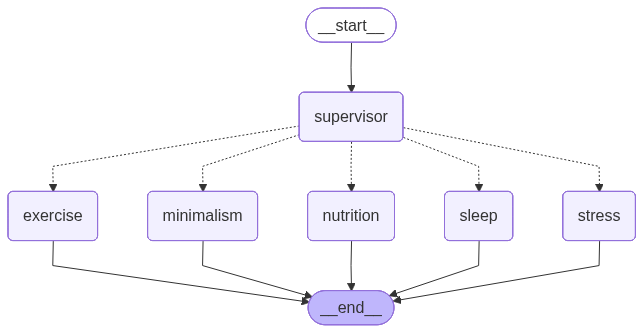

In [57]:
# Visualize the graph
try:
    from IPython.display import display, Image
    display(Image(supervisor_new_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(supervisor_new_graph.get_graph().draw_ascii())

---
#  🤝 Breakout Room #2
## Handoffs & Context Engineering

## Task 5: Agent Handoffs Pattern

The **Handoffs Pattern** allows agents to transfer control to each other based on the conversation context. Unlike the supervisor pattern, agents decide themselves when to hand off.

```
    User Question
         │
         ▼
    ┌─────────┐    "I need nutrition help"   ┌─────────┐
    │ Fitness │ ─────────────────────────────► Nutrition│
    │  Agent  │                               │  Agent  │
    └─────────┘ ◄───────────────────────────── └─────────┘
                 "Back to fitness questions"
```

**Documentation:**
- [LangGraph Agent Handoffs](https://langchain-ai.github.io/langgraph/how-tos/agent-handoffs/)

In [29]:
# Create handoff tools that agents can use to transfer control
# Each tool returns a special HANDOFF string that the graph will detect

@tool
def transfer_to_exercise(reason: str) -> str:
    """Transfer to Exercise Specialist for fitness, workouts, and physical activity questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:exercise:{reason}"

@tool
def transfer_to_nutrition(reason: str) -> str:
    """Transfer to Nutrition Specialist for diet, meal planning, and food questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:nutrition:{reason}"

@tool
def transfer_to_sleep(reason: str) -> str:
    """Transfer to Sleep Specialist for sleep quality, insomnia, and rest questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:sleep:{reason}"

@tool
def transfer_to_stress(reason: str) -> str:
    """Transfer to Stress Management Specialist for stress, anxiety, and mindfulness questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:stress:{reason}"

print("Handoff tools created!")

Handoff tools created!


In [30]:
# Create agents with handoff capabilities (using create_agent)

exercise_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_exercise_info,
        transfer_to_nutrition,
        transfer_to_sleep,
        transfer_to_stress
    ],
    system_prompt="""You are an Exercise Specialist. Answer fitness and workout questions.
If the user's question is better suited for another specialist, use the appropriate transfer tool.
Always search the knowledge base before answering exercise questions."""
)

nutrition_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_nutrition_info,
        transfer_to_exercise,
        transfer_to_sleep,
        transfer_to_stress
    ],
    system_prompt="""You are a Nutrition Specialist. Answer diet and meal planning questions.
If the user's question is better suited for another specialist, use the appropriate transfer tool.
Always search the knowledge base before answering nutrition questions."""
)

sleep_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_sleep_info,
        transfer_to_exercise,
        transfer_to_nutrition,
        transfer_to_stress
    ],
    system_prompt="""You are a Sleep Specialist. Answer sleep and rest questions.
If the user's question is better suited for another specialist, use the appropriate transfer tool.
Always search the knowledge base before answering sleep questions."""
)

stress_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_stress_info,
        transfer_to_exercise,
        transfer_to_nutrition,
        transfer_to_sleep
    ],
    system_prompt="""You are a Stress Management Specialist. Answer stress and mindfulness questions.
If the user's question is better suited for another specialist, use the appropriate transfer tool.
Always search the knowledge base before answering stress questions."""
)

print("Handoff-enabled agents created (using create_agent)!")

Handoff-enabled agents created (using create_agent)!


In [31]:
# Build the handoff graph with transfer limit to prevent infinite loops

class HandoffState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    current_agent: str
    transfer_count: int  # Track transfers to prevent infinite loops

MAX_TRANSFERS = 2  # Maximum number of handoffs allowed

def parse_handoff(content: str) -> tuple[bool, str, str]:
    """Parse a handoff from agent response."""
    if "HANDOFF:" in content:
        parts = content.split("HANDOFF:")[1].split(":")
        return True, parts[0], parts[1] if len(parts) > 1 else ""
    return False, "", ""

def create_handoff_node(agent, name: str):
    """Create a node that can handle handoffs."""
    def node(state: HandoffState):
        print(f"[{name.upper()} Agent] Processing...")
        result = agent.invoke({"messages": state["messages"]})
        last_message = result["messages"][-1]
        
        # Check for handoff in tool messages (only if under transfer limit)
        if state["transfer_count"] < MAX_TRANSFERS:
            for msg in result["messages"]:
                if hasattr(msg, 'content') and "HANDOFF:" in str(msg.content):
                    is_handoff, target, reason = parse_handoff(str(msg.content))
                    if is_handoff:
                        print(f"[{name.upper()}] Handing off to {target}: {reason}")
                        return {
                            "messages": [AIMessage(content=f"[{name}] Transferring to {target} specialist: {reason}")],
                            "current_agent": target,
                            "transfer_count": state["transfer_count"] + 1
                        }
        
        # No handoff (or limit reached), return final response
        response = AIMessage(
            content=f"[{name.upper()} SPECIALIST]\n\n{last_message.content}",
            name=name
        )
        print(f"[{name.upper()} Agent] Response complete.")
        return {"messages": [response], "current_agent": "done", "transfer_count": state["transfer_count"]}
    
    return node

# Create nodes
exercise_handoff_node = create_handoff_node(exercise_handoff_agent, "exercise")
nutrition_handoff_node = create_handoff_node(nutrition_handoff_agent, "nutrition")
sleep_handoff_node = create_handoff_node(sleep_handoff_agent, "sleep")
stress_handoff_node = create_handoff_node(stress_handoff_agent, "stress")

print("Handoff nodes created!")

Handoff nodes created!


In [32]:
# Build the handoff graph with initial routing (using GPT-5.2)

def entry_router(state: HandoffState):
    """Initial routing based on the user's question (using GPT-5.2)."""
    user_question = state['messages'][-1].content
    
    router_prompt = f"""Based on this question, which specialist should handle it?
Options: exercise, nutrition, sleep, stress

Question: {user_question}

Respond with just the specialist name (one word)."""
    
    response = supervisor_llm.invoke(router_prompt)
    agent = response.content.strip().lower()
    
    # Validate
    if agent not in ["exercise", "nutrition", "sleep", "stress"]:
        agent = "stress"  # Default to stress for general wellness
    
    print(f"[Router GPT-5.2] Initial routing to: {agent}")
    return {"current_agent": agent, "transfer_count": 0}

def route_by_current_agent(state: HandoffState) -> str:
    """Route based on current_agent field."""
    return state["current_agent"]

# Build graph
handoff_workflow = StateGraph(HandoffState)

# Add nodes
handoff_workflow.add_node("router", entry_router)
handoff_workflow.add_node("exercise", exercise_handoff_node)
handoff_workflow.add_node("nutrition", nutrition_handoff_node)
handoff_workflow.add_node("sleep", sleep_handoff_node)
handoff_workflow.add_node("stress", stress_handoff_node)

# Entry point
handoff_workflow.add_edge(START, "router")

# Router to agents
handoff_workflow.add_conditional_edges(
    "router",
    route_by_current_agent,
    {"exercise": "exercise", "nutrition": "nutrition", "sleep": "sleep", "stress": "stress"}
)

# Agents can handoff to each other or end
for agent_name in ["exercise", "nutrition", "sleep", "stress"]:
    handoff_workflow.add_conditional_edges(
        agent_name,
        route_by_current_agent,
        {
            "exercise": "exercise",
            "nutrition": "nutrition", 
            "sleep": "sleep",
            "stress": "stress",
            "done": END
        }
    )

# Compile
handoff_graph = handoff_workflow.compile()

print("Handoff multi-agent system built!")

Handoff multi-agent system built!


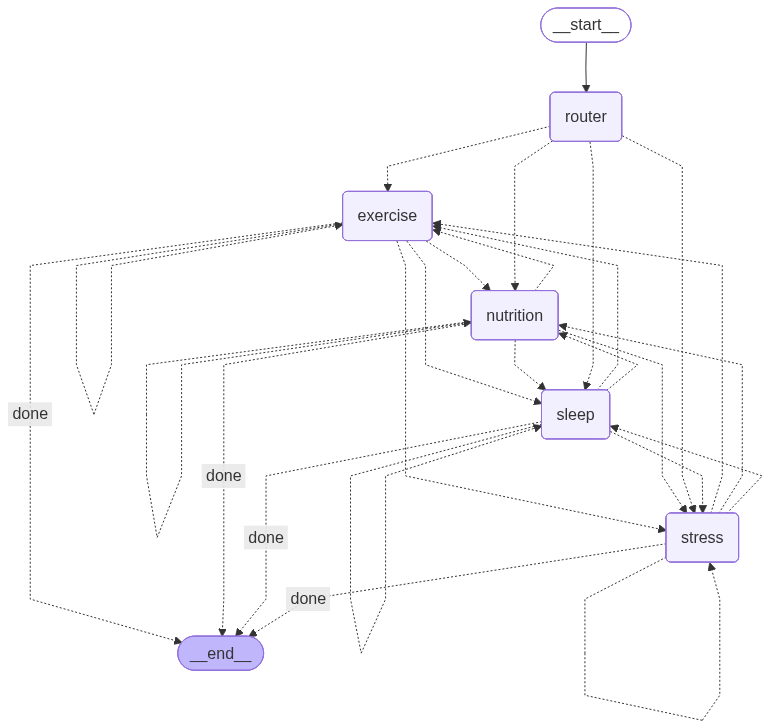

In [33]:
# Visualize the handoff graph
try:
    from IPython.display import display, Image
    display(Image(handoff_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(handoff_graph.get_graph().draw_ascii())

In [35]:
# Test the handoff system
print("Testing Handoff System")
print("=" * 50)

response = handoff_graph.invoke({
    "messages": [HumanMessage(content="I'm stressed and can't sleep. What should I do?")],
    "current_agent": "",
    "transfer_count": 0
})

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Handoff System
[Router GPT-5.2] Initial routing to: stress
[STRESS Agent] Processing...
[STRESS] Handing off to sleep: User is experiencing sleep issues.
[SLEEP Agent] Processing...
[SLEEP] Handing off to stress: User is experiencing stress that is affecting their sleep.
[STRESS Agent] Processing...
[STRESS Agent] Response complete.

FINAL RESPONSE:
[STRESS SPECIALIST]

I recommend reaching out to a Sleep Specialist for guidance on improving your sleep quality, especially since stress can significantly impact your ability to rest. They can provide tailored strategies to help you manage both stress and sleep issues effectively.


## Task 6: Building a Wellness Agent Team

Now let's combine what we've learned to build a complete wellness team that can:
1. Handle complex multi-domain questions
2. Search both the knowledge base and the web
3. Maintain conversation context
4. Provide comprehensive wellness advice

In [36]:
# Create a unified wellness team with memory
from langgraph.checkpoint.memory import MemorySaver

# Add memory to the supervisor graph
memory = MemorySaver()

supervisor_with_memory = supervisor_workflow.compile(checkpointer=memory)

print("Supervisor with memory created!")

Supervisor with memory created!


In [37]:
# Test multi-turn conversation
thread_id = "wellness-session-1"
config = {"configurable": {"thread_id": thread_id}}

print("Multi-turn Conversation Test")
print("=" * 50)

# First question
response1 = supervisor_with_memory.invoke(
    {"messages": [HumanMessage(content="What's a good morning routine for energy?")]},
    config=config
)
print("\n[Turn 1 Response]:")
print(response1["messages"][-1].content[:500])

Multi-turn Conversation Test
[Supervisor GPT-5.2] Routing to: sleep
  Reason: A morning routine for energy is most strongly driven by sleep quality and circadian timing (wake time consistency, light exposure, hydration, and wake-up behaviors). While exercise and nutrition can contribute, the primary lever for sustained morning energy is sleep and circadian alignment, so the sleep specialist is the best fit.
[SLEEP Agent] Processing request...
[SLEEP Agent] Response complete.

[Turn 1 Response]:
[SLEEP SPECIALIST]

A good morning routine for energy includes the following steps:

1. **Wake at a Consistent Time**: Try to get up at the same time every day to regulate your body's internal clock.
2. **Hydrate**: Drink a glass of water immediately after waking to rehydrate your body.
3. **Light Movement**: Engage in 5-10 minutes of stretching or light exercise to get your blood flowing.
4. **Healthy Breakfast**: Eat a nutritious breakfast that includes protein, healthy fats, and whole grains.

In [38]:
# Follow-up question (should remember context)
response2 = supervisor_with_memory.invoke(
    {"messages": [HumanMessage(content="What should I eat as part of that routine?")]},
    config=config
)
print("\n[Turn 2 Response]:")
print(response2["messages"][-1].content[:500])

[Supervisor GPT-5.2] Routing to: nutrition
  Reason: The user is asking what to eat as part of a routine, which is a diet/meal-planning question best handled by the nutrition specialist.
[NUTRITION Agent] Processing request...
[NUTRITION Agent] Response complete.

[Turn 2 Response]:
[NUTRITION SPECIALIST]

For a healthy breakfast that boosts energy, consider the following options:

1. **Overnight Oats**: Combine rolled oats with milk or yogurt, and top with berries and nuts for added fiber and healthy fats.
2. **Smoothie Bowl**: Blend spinach, banana, and a scoop of protein powder, then top with granola and seeds.
3. **Avocado Toast**: Whole grain bread topped with smashed avocado, a sprinkle of salt, and a poached egg for protein.
4. **Greek Yogurt Parfait**: Layer Greek y


## Task 7: Context Engineering & Optimization

As conversations grow, we need to manage context carefully. Key principles:

1. **Context Window as Prime Real Estate**: Only include what's necessary
2. **Summarization**: Compress long conversations
3. **Selective Retrieval**: Don't retrieve everything, just what's relevant
4. **Context Rot**: More tokens doesn't mean better performance

In [39]:
# Implement a context summarization function (using GPT-4o-mini for cost efficiency)

def summarize_conversation(messages: list[BaseMessage], max_messages: int = 6) -> list[BaseMessage]:
    """Summarize older messages to manage context length."""
    if len(messages) <= max_messages:
        return messages
    
    # Keep the first message (original question) and last few messages
    old_messages = messages[1:-max_messages+1]
    recent_messages = messages[-max_messages+1:]
    
    # Summarize old messages
    summary_prompt = f"""Summarize this conversation history in 2-3 sentences, 
capturing the key topics discussed and any important decisions made:

{chr(10).join([f'{m.type}: {m.content[:200]}' for m in old_messages])}"""
    
    summary = specialist_llm.invoke(summary_prompt)
    
    # Return: first message + summary + recent messages
    return [
        messages[0],
        SystemMessage(content=f"[Previous conversation summary: {summary.content}]"),
        *recent_messages
    ]

print("Context summarization function created!")

Context summarization function created!


In [40]:
# Demonstrate context optimization
sample_messages = [
    HumanMessage(content="I want to get healthier"),
    AIMessage(content="Great! Let's start with your goals."),
    HumanMessage(content="I want to lose weight and sleep better"),
    AIMessage(content="Here are some exercise tips..."),
    HumanMessage(content="What about diet?"),
    AIMessage(content="For nutrition, consider..."),
    HumanMessage(content="And sleep?"),
    AIMessage(content="For better sleep..."),
    HumanMessage(content="How do I manage stress?"),
]

print(f"Original messages: {len(sample_messages)}")

optimized = summarize_conversation(sample_messages, max_messages=4)
print(f"Optimized messages: {len(optimized)}")
print("\nOptimized conversation:")
for msg in optimized:
    print(f"  [{msg.type}]: {msg.content[:100]}...")

Original messages: 9
Optimized messages: 5

Optimized conversation:
  [human]: I want to get healthier...
  [system]: [Previous conversation summary: The conversation focused on the human's goals of losing weight and i...
  [human]: And sleep?...
  [ai]: For better sleep......
  [human]: How do I manage stress?...


---
## ❓ Question #3:

Compare the **Supervisor pattern** and the **Handoffs pattern** we implemented. What are the key differences in how routing decisions are made? When would you choose one pattern over the other?

##### Answer:
In the supervisor pattern, once the supervisor routes to an agent, that agents provides the response. If a query is best answered by a combination of specialist agents, then the supervisor pattern just directs to the most probable agent (or could be random, if more than one is equally probable) and thereby the response may be incomplete to the user.
In the handoff pattern, each agent has the capability to handoff to another another if it determines the query can be better answered by the other agent. In this pattern, we should implement in such a way that any relevant information an agent has is passed on as response during handoff (besides agent name and reason) and the second agent uses this info while it geenrates its own response. This makes sure that the final response will have a more comprehensive answer as the query warrants it.

## ❓ Question #4:

We discussed "Context Rot" - the idea that longer context doesn't always mean better performance. How does this principle apply to multi-agent systems? What strategies can you use to manage context effectively across multiple agents?

##### Answer:
As the number of agents and/or handoffs increase, the context (aka state) becomes longer and longer, and latency increases. With longer context, the model may miss key information and the final response may not be really cohesive enough to be useful.
To control context rot in multi-agent systems, a couple of things can be done:
- use a minimum number of agents for your use case
- limit the number of transfers/handoffs
- can summarize the context periodically (as the length increases than a limit)

---
## 🏗️ Activity #2: Implement Hierarchical Teams

Build a **Hierarchical Agent System** where a top-level supervisor manages multiple team supervisors, each with their own specialist agents.

### Requirements:

1. Create a **Wellness Director** (top-level supervisor using GPT-5.2) that:
   - Receives user questions and determines which team should handle it
   - Routes to either the "Physical Wellness Team" or "Mental Wellness Team"
   - Aggregates final responses from teams

2. Create two **Team Supervisors**:
   - **Physical Wellness Team Lead**: Manages Exercise Agent and Nutrition Agent
   - **Mental Wellness Team Lead**: Manages Sleep Agent and Stress Agent

3. Implement the hierarchical routing:
   - User question → Wellness Director → Team Lead → Specialist Agent → Response

4. Test with questions that require different teams:
   - "What exercises help with weight loss?" (Physical team)
   - "How can I improve my sleep when stressed?" (Mental team)

### Architecture:
```
                    ┌─────────────────────┐
                    │  Wellness Director  │
                    │     (GPT-5.2)       │
                    └──────────┬──────────┘
                               │
              ┌────────────────┴────────────────┐
              │                                 │
              ▼                                 ▼
   ┌─────────────────────┐          ┌─────────────────────┐
   │  Physical Wellness  │          │  Mental Wellness    │
   │    Team Lead        │          │    Team Lead        │
   └──────────┬──────────┘          └──────────┬──────────┘
              │                                 │
       ┌──────┴──────┐                   ┌──────┴──────┐
       │             │                   │             │
       ▼             ▼                   ▼             ▼
  ┌─────────┐  ┌──────────┐        ┌─────────┐  ┌─────────┐
  │Exercise │  │Nutrition │        │  Sleep  │  │ Stress  │
  │  Agent  │  │  Agent   │        │  Agent  │  │  Agent  │
  └─────────┘  └──────────┘        └─────────┘  └─────────┘
```

**Documentation:**
- [LangGraph Hierarchical Teams](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/)

In [ ]:
### YOUR CODE HERE ###

# Step 1: Create Team Supervisors (using GPT-5.2 for routing)
# These manage routing within their teams

class TeamRouterOutput(BaseModel):
    """Team supervisor routing decision."""
    next: str  # The specialist to route to within the team
    reasoning: str

# Physical Wellness Team Lead
physical_team_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Physical Wellness Team Lead.
Your team has two specialists:
- exercise: Handles fitness, workouts, and physical activity
- nutrition: Handles diet, meal planning, and healthy eating

Route to the most appropriate specialist for the user's question."""),
    ("human", "Question: {question}")
])

# Mental Wellness Team Lead  
mental_team_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Mental Wellness Team Lead.
Your team has two specialists:
- sleep: Handles sleep quality, insomnia, and rest
- stress: Handles stress management, mindfulness, and mental wellness

Route to the most appropriate specialist for the user's question."""),
    ("human", "Question: {question}")
])

team_routing_llm = supervisor_llm.with_structured_output(TeamRouterOutput)

def physical_team_node(state: SupervisorState):
    """The physical team lead decides which specialist to route to."""
    # Get the user's question from the last human message
    user_question = ""
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):   
            user_question = msg.content
            break
    
    # Get routing decision
    prompt_value = physical_team_prompt.invoke({"question": user_question})
    result = team_routing_llm.invoke(prompt_value)    
    

    print(f"[Physical Team Lead] Routing to: {result.next}")
    print(f"  Reason: {result.reasoning}")
    return {"next": result.next}



def mental_team_node(state: SupervisorState):
    """The mental team lead decides which specialist to route to."""
    # Get the user's question from the last human message
    user_question = ""
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            user_question = msg.content
            break   
    
    # Get routing decision
    prompt_value = mental_team_prompt.invoke({"question": user_question})
    result = team_routing_llm.invoke(prompt_value)
    

    print(f"[Mental Team Lead] Routing to: {result.next}")
    print(f"  Reason: {result.reasoning}")  
    return {"next": result.next}



# Step 2: Create the Wellness Director (top-level, using GPT-5.2)
class DirectorRouterOutput(BaseModel):
    """Director routing decision to teams."""
    team: Literal["physical", "mental"]
    reasoning: str

director_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Wellness Director overseeing two teams:
- physical: Physical Wellness Team (exercise, nutrition)
- mental: Mental Wellness Team (sleep, stress)

Route to the appropriate team based on the user's question."""),
    ("human", "Question: {question}")
])

# Step 3: Build the hierarchical graph
# Hint: You'll need nested graphs or a state that tracks the current level
director_routing_llm = supervisor_llm.with_structured_output(DirectorRouterOutput)

def director_node(state: SupervisorState):
    """The director decides which team to route to."""
    # Get the user's question from the last human message
    user_question = ""
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            user_question = msg.content
            break
    
    # Get routing decision
    prompt_value = director_prompt.invoke({"question": user_question})
    result = director_routing_llm.invoke(prompt_value)
    
    print(f"[Supervisor GPT-5.2] Routing to: {result.team}")
    print(f"  Reason: {result.reasoning}")
    
    return {"next": result.team}

director_workflow = StateGraph(SupervisorState)

def route_by_next(state: SupervisorState) -> str:
    """Route based on the 'next' field in the state."""
    return state["next"]

# Add nodes
director_workflow.add_node("director", director_node)
director_workflow.add_node("physical", physical_team_node)
director_workflow.add_node("mental", mental_team_node)
director_workflow.add_node("exercise", exercise_node)
director_workflow.add_node("nutrition", nutrition_node)
director_workflow.add_node("sleep", sleep_node)
director_workflow.add_node("stress", stress_node)

# Add edges: START -> director
director_workflow.add_edge(START, "director")

director_workflow.add_conditional_edges(
    "director",
    route_by_next,
    {
        "physical": "physical",
        "mental": "mental",
    }
)

director_workflow.add_conditional_edges(
    "physical",
    route_by_next,
    {
        "exercise": "exercise",
        "nutrition": "nutrition",
    }
)

director_workflow.add_conditional_edges(
    "mental",
    route_by_next,
    {
        "sleep": "sleep",
        "stress": "stress",
    }
)

director_workflow.add_edge("exercise", END)
director_workflow.add_edge("nutrition", END)
director_workflow.add_edge("sleep", END)
director_workflow.add_edge("stress", END)

director_graph = director_workflow.compile()


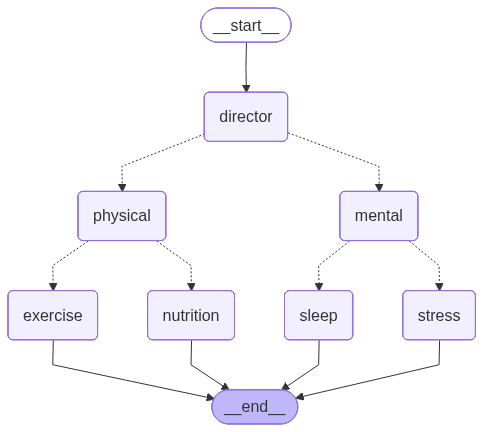

In [59]:
# Visualize the graph
try:
    from IPython.display import display, Image
    display(Image(director_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")


In [60]:
# Step 4: Test the hierarchical system
test_question = "What exercises help with weight loss?"
response = director_graph.invoke({"messages": [HumanMessage(content=test_question)]})
print(response["messages"][-1].content)

[Supervisor GPT-5.2] Routing to: physical
  Reason: The user is asking about exercises for weight loss, which falls under exercise and physical wellness guidance.
[Physical Team Lead] Routing to: exercise
  Reason: The user is asking which exercises help with weight loss, which is primarily a fitness/workout programming question best handled by the exercise specialist.
[EXERCISE Agent] Processing request...
[EXERCISE Agent] Response complete.
[EXERCISE SPECIALIST]

To aid in weight loss, a combination of different types of exercises is effective. Here are some key exercises and activities to consider:

1. **Aerobic (Cardio) Exercises**: Aim for at least 150 minutes of moderate-intensity aerobic activity per week. Examples include:
   - Walking
   - Running
   - Cycling
   - Swimming
   - Dancing

2. **Strength Training**: Incorporate muscle-strengthening activities on 2 or more days per week. This can include:
   - Bodyweight exercises (squats, push-ups, planks)
   - Weight lifting
   

In [61]:
# Step 4: Test the hierarchical system
test_question = "What are some tips to manage my anxiety during presentations?"
response = director_graph.invoke({"messages": [HumanMessage(content=test_question)]})
print(response["messages"][-1].content)

[Supervisor GPT-5.2] Routing to: mental
  Reason: The user is asking for strategies to manage anxiety during presentations, which falls under stress/anxiety management within mental wellness.
[Mental Team Lead] Routing to: stress
  Reason: Presentation anxiety is primarily a stress/anxiety management issue (performance nerves, coping strategies, mindfulness, and cognitive/behavioral tools). The stress specialist is best suited to provide actionable techniques for calming the nervous system, reframing thoughts, and improving confidence during presentations.
[STRESS Agent] Processing request...
[STRESS Agent] Response complete.
[STRESS SPECIALIST]

Here are some tips to manage anxiety during presentations:

1. **Preparation**: Know your material well. Practice multiple times to build confidence.

2. **Visualization**: Imagine yourself giving a successful presentation. This can help reduce anxiety.

3. **Breathing Techniques**: Use deep breathing exercises to calm your nerves before and d

In [68]:
# Create a hierarchical agent system with nested graphs

physical_team_workflow = StateGraph(SupervisorState)

physical_team_workflow.add_node("physical", physical_team_node)
physical_team_workflow.add_node("exercise", exercise_node)
physical_team_workflow.add_node("nutrition", nutrition_node)

physical_team_workflow.add_edge(START, "physical")
physical_team_workflow.add_conditional_edges(
    "physical",
    route_by_next,
    {
        "exercise": "exercise",
        "nutrition": "nutrition",
    }
)

physical_team_workflow.add_edge("exercise", END)
physical_team_workflow.add_edge("nutrition", END)

physical_team_graph = physical_team_workflow.compile()


mental_team_workflow = StateGraph(SupervisorState)

mental_team_workflow.add_node("mental", mental_team_node)
mental_team_workflow.add_node("sleep", sleep_node)
mental_team_workflow.add_node("stress", stress_node)

mental_team_workflow.add_edge(START, "mental")
mental_team_workflow.add_conditional_edges(
    "mental",
    route_by_next,
    {
        "sleep": "sleep",
        "stress": "stress",
    }
)

mental_team_workflow.add_edge("sleep", END)
mental_team_workflow.add_edge("stress", END)    

mental_team_graph = mental_team_workflow.compile()

# Create the Wellness Director (top-level)
hierarchical_workflow = StateGraph(SupervisorState)

hierarchical_workflow.add_node("director", director_node)
hierarchical_workflow.add_node("physical", physical_team_graph)
hierarchical_workflow.add_node("mental", mental_team_graph)

hierarchical_workflow.add_edge(START, "director")
hierarchical_workflow.add_conditional_edges(
    "director",
    route_by_next,
    {
        "physical": "physical",
        "mental": "mental",
    }
)

hierarchical_workflow.add_edge("physical", END)
hierarchical_workflow.add_edge("mental", END)

hierarchical_graph = hierarchical_workflow.compile()


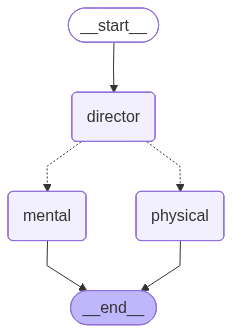

In [69]:
# Visualize the graph
try:
    from IPython.display import display, Image
    display(Image(hierarchical_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")


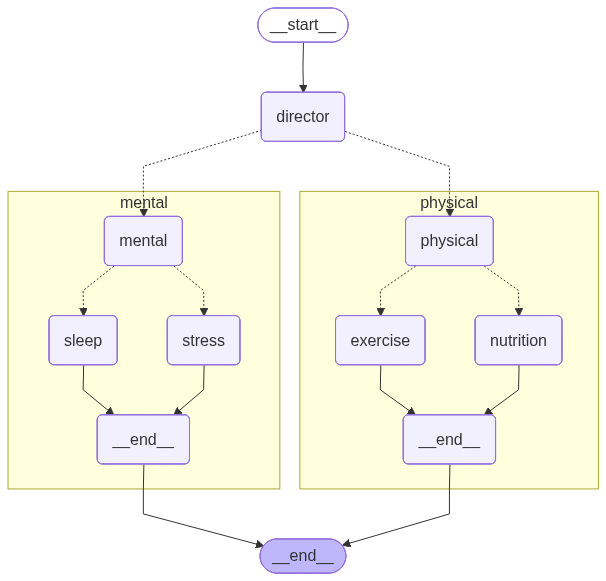

In [73]:
# Visualize the graph
try:
    from IPython.display import display, Image
    display(Image(hierarchical_graph.get_graph(xray=1).draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

In [70]:
# Step 4: Test the hierarchical system
test_question = "What exercises help with increasing stamina?"
response = hierarchical_graph.invoke({"messages": [HumanMessage(content=test_question)]})
print(response["messages"][-1].content)

[Supervisor GPT-5.2] Routing to: physical
  Reason: The user is asking about exercises to increase stamina, which falls under exercise training and physical conditioning handled by the Physical Wellness Team.
[Physical Team Lead] Routing to: exercise
  Reason: The user asks which exercises increase stamina, which falls under fitness training, cardio/endurance conditioning, and workout recommendations—best handled by the exercise specialist.
[EXERCISE Agent] Processing request...
[EXERCISE Agent] Response complete.
[EXERCISE SPECIALIST]

To increase stamina, focus on aerobic (cardio) exercises, which are essential for building endurance. Here are some effective exercises:

1. **Walking or Jogging**: Start with brisk walking and gradually increase to jogging.
2. **Cycling**: Whether on a stationary bike or outdoors, cycling is great for stamina.
3. **Swimming**: A full-body workout that enhances cardiovascular endurance.
4. **Jump Rope**: A high-intensity exercise that boosts heart rate 

In [71]:
# Step 4: Test the hierarchical system
test_question = "How to be more happy?"
response = hierarchical_graph.invoke({"messages": [HumanMessage(content=test_question)]})
print(response["messages"][-1].content)

[Supervisor GPT-5.2] Routing to: mental
  Reason: The user is asking how to be more happy, which primarily relates to mental wellness factors like mood, stress management, sleep, mindset, and emotional health.
[Mental Team Lead] Routing to: stress
  Reason: User asks about becoming happier, which fits stress management and overall mental wellness (mindset, habits, social connection, meaning). Sleep may be relevant but not the primary focus.
[STRESS Agent] Processing request...
[STRESS Agent] Response complete.
[STRESS SPECIALIST]

To enhance your happiness, consider the following strategies:

1. **Regular Exercise**: Physical activity boosts endorphins, which can improve your mood.
2. **Adequate Sleep**: Prioritize restful sleep to help regulate your emotions.
3. **Social Connections**: Foster relationships and seek support from friends and family.
4. **Engage in Hobbies**: Spend time on activities you enjoy to bring joy into your life.
5. **Mindfulness and Meditation**: Practice being

---
## Summary

In this session, we:

1. **Understood Multi-Agent Systems**: When to use them and key patterns
2. **Built a Supervisor Pattern**: Central orchestrator routing to specialists
3. **Implemented Agent Handoffs**: Agents transferring control to each other
4. **Added Web Search**: Tavily for current information alongside knowledge base
5. **Applied Context Engineering**: Managing context for optimal performance

### Key Takeaways:

- **Don't over-engineer**: Only add agents when you truly need specialization
- **Context is key**: Manage your context window carefully
- **Patterns matter**: Choose the right pattern for your use case

**Further Reading:**
- [Building Effective Agents (Anthropic)](https://www.anthropic.com/engineering/building-effective-agents)
- [Don't Build Multi-Agents (Cognition)](https://cognition.ai/blog/dont-build-multi-agents)
- [12-Factor Agents](https://github.com/humanlayer/12-factor-agents)